In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb 
import tensorflow as tf
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import plot_importance, plot_tree
import re
#import plotly.graph_objects as go
from pandas import Series
import graphviz

In [5]:
pathToData = "/Users/qw19176/Documents/Courses/datathonJan/"
dataFile = pathToData+"preprocessed.csv"

data = pd.read_csv(dataFile)
data.head()


,Airbags_Deployed,LossCause_Fire,LossCause_InsuredHitTP,LossCause_MechanicalFailure,LossCause_Other,LossCause_TPHitInsured,LossCause_Theft,LossCause_Weather,VehicleType_C,VehicleType_M,VehicleType_V,ReportingDelay,Age,Damage_Front,Damage_Rear,Damage_Left,Damage_Right,TOTAL_LOSS
0,0,0,0,0,0,0,0,1,1,0,0,0,17.0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,1,0,0,8,20.0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,0,55,17.0,0,1,0,0,0
3,1,0,1,0,0,0,0,0,1,0,0,305,17.0,1,0,1,0,1
4,1,0,1,0,0,0,0,0,1,0,0,180,40.0,0,0,0,1,0


In [6]:
def mono_bin(Y, X, n = 16):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

In [7]:
#dataWithPics = data[data["Image"]=="Y"]
import traceback
def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [8]:
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

In [9]:
dataWoe = [go.Bar(
            x=final_iv['Age'],
            y=final_iv['WOE'],
            text=final_iv['Age'],
            marker=dict(
            color='rgb(158,20,25)',
            line=dict(
            color='rgb(8,48,107)',
            width=1.5,
        )
    ),
    opacity=0.6
    )]


layout = go.Layout(
    title='Weight of Evidence(WOE)',
        xaxis=dict(
        title='Features',
            tickangle=-45,
        tickfont=dict(
            size=10,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Weight of Evidence(WOE)',
        titlefont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
)

plotly.offline.iplot({
    "data": data,'layout':layout
})

NameError: name 'go' is not defined

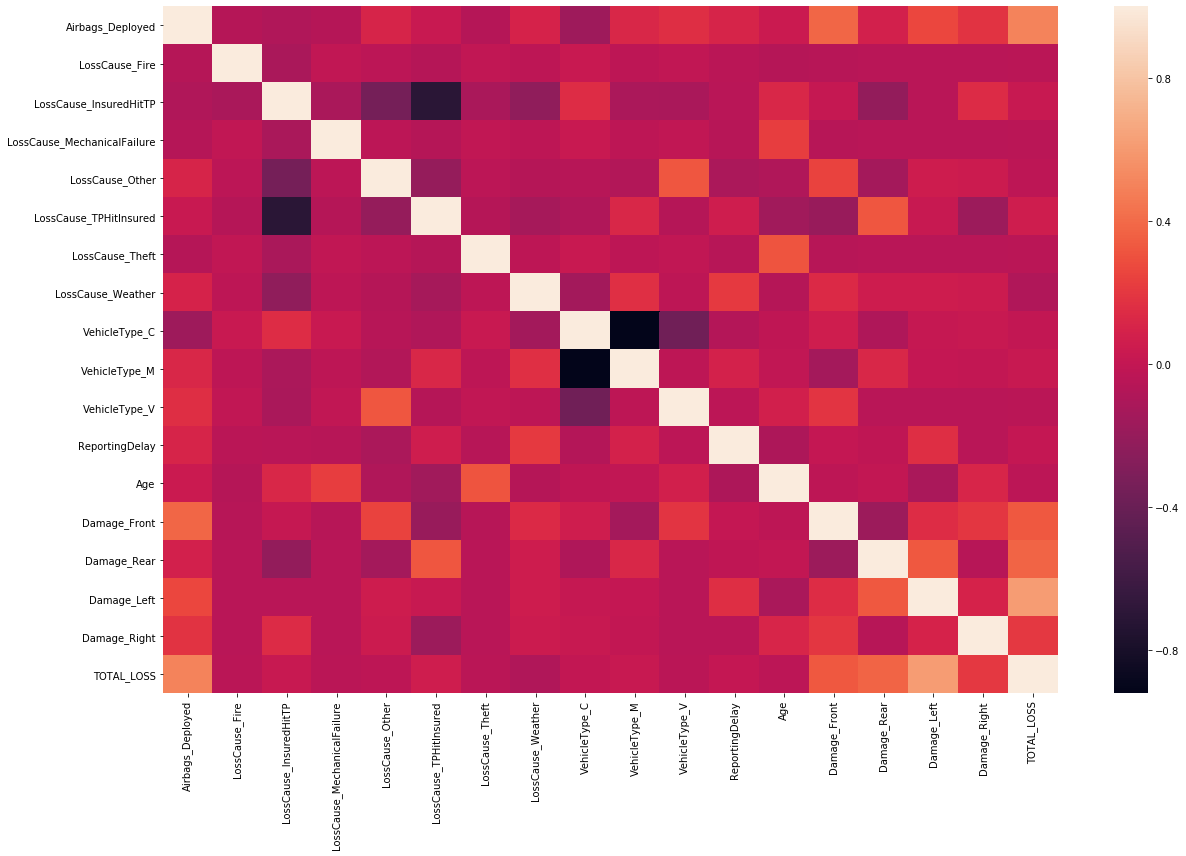

In [25]:
correl = data.corr()
fig, ax = plt.subplots(figsize=(18,12))
sns.heatmap(correl, xticklabels=correl.columns, yticklabels=correl.columns)
plt.tight_layout()
plt.show()
fig.savefig('correlationg.png')

In [11]:
correl

,Airbags_Deployed,LossCause_Fire,LossCause_InsuredHitTP,LossCause_MechanicalFailure,LossCause_Other,LossCause_TPHitInsured,LossCause_Theft,LossCause_Weather,VehicleType_C,VehicleType_M,VehicleType_V,ReportingDelay,Age,Damage_Front,Damage_Rear,Damage_Left,Damage_Right,TOTAL_LOSS
Airbags_Deployed,1.000000,-0.064232,-0.086381,-0.064232,0.107040,0.028655,-0.064232,0.094468,-0.170156,0.116924,0.157258,0.102403,0.034413,0.383854,0.081754,0.262095,0.180114,0.504289
LossCause_Fire,-0.064232,1.000000,-0.111111,-0.010101,-0.031607,-0.064232,-0.010101,-0.020515,0.027573,-0.025392,-0.010101,-0.037652,-0.060623,-0.054929,-0.043863,-0.043863,-0.045485,-0.040551
LossCause_InsuredHitTP,-0.086381,-0.111111,1.000000,-0.111111,-0.347677,-0.706553,-0.111111,-0.225668,0.145745,-0.110031,-0.111111,-0.047303,0.117280,0.016717,-0.208351,-0.043863,0.141806,0.017379
LossCause_MechanicalFailure,-0.064232,-0.010101,-0.111111,1.000000,-0.031607,-0.064232,-0.010101,-0.020515,0.027573,-0.025392,-0.010101,-0.053854,0.222663,-0.054929,-0.043863,-0.043863,-0.045485,-0.040551
LossCause_Other,0.107040,-0.031607,-0.347677,-0.031607,1.000000,-0.200988,-0.031607,-0.064194,-0.050672,-0.079453,0.319582,-0.109735,-0.083324,0.243286,-0.137253,0.053376,0.043721,-0.026183
LossCause_TPHitInsured,0.028655,-0.064232,-0.706553,-0.064232,-0.200988,1.000000,-0.064232,-0.130456,-0.083782,0.116924,-0.064232,0.061624,-0.154424,-0.192189,0.322208,0.021641,-0.171900,0.059702
LossCause_Theft,-0.064232,-0.010101,-0.111111,-0.010101,-0.031607,-0.064232,1.000000,-0.020515,0.027573,-0.025392,-0.010101,-0.053854,0.313314,-0.054929,-0.043863,-0.043863,-0.045485,-0.040551
LossCause_Weather,0.094468,-0.020515,-0.225668,-0.020515,-0.064194,-0.130456,-0.020515,1.000000,-0.144005,0.163308,-0.020515,0.211460,-0.059837,0.130963,0.050111,0.050111,0.043473,-0.082359
VehicleType_C,-0.170156,0.027573,0.145745,0.027573,-0.050672,-0.083782,0.027573,-0.144005,1.000000,-0.920882,-0.366332,-0.068086,-0.020106,0.056811,-0.094079,0.012829,0.019824,-0.002259
VehicleType_M,0.116924,-0.025392,-0.110031,-0.025392,-0.079453,0.116924,-0.025392,0.163308,-0.920882,1.000000,-0.025392,0.087448,-0.009970,-0.138080,0.119452,0.004594,-0.002242,0.019416


In [12]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import train_test_split
plt.style.use('fivethirtyeight')

ModuleNotFoundError: No module named 'train_test_split'

In [13]:
from sklearn.model_selection import train_test_split

y = data.iloc[:,-1]
X = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model = xgb.XGBRegressor(
    n_estimators=1000,
    #max_depth=4,
    #min_child_weight=300, 
    #colsample_bytree=0.8, 
    #subsample=0.8, 
    #eta=0.1,    
    #seed=42
    )

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False, 
    early_stopping_rounds = 100)

[17:53:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
/anaconda3/envs/datathonEn/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [14]:
model.feature_importances_

array([1.6531177e-01, 0.0000000e+00, 1.0839781e-01, 0.0000000e+00,
       9.9606756e-03, 2.7569593e-03, 0.0000000e+00, 1.1178915e-01,
       6.0310063e-05, 2.0893390e-04, 4.3501039e-03, 4.1339055e-02,
       1.1763819e-02, 5.2977279e-02, 3.1074869e-02, 4.5112807e-01,
       8.8811629e-03], dtype=float32)

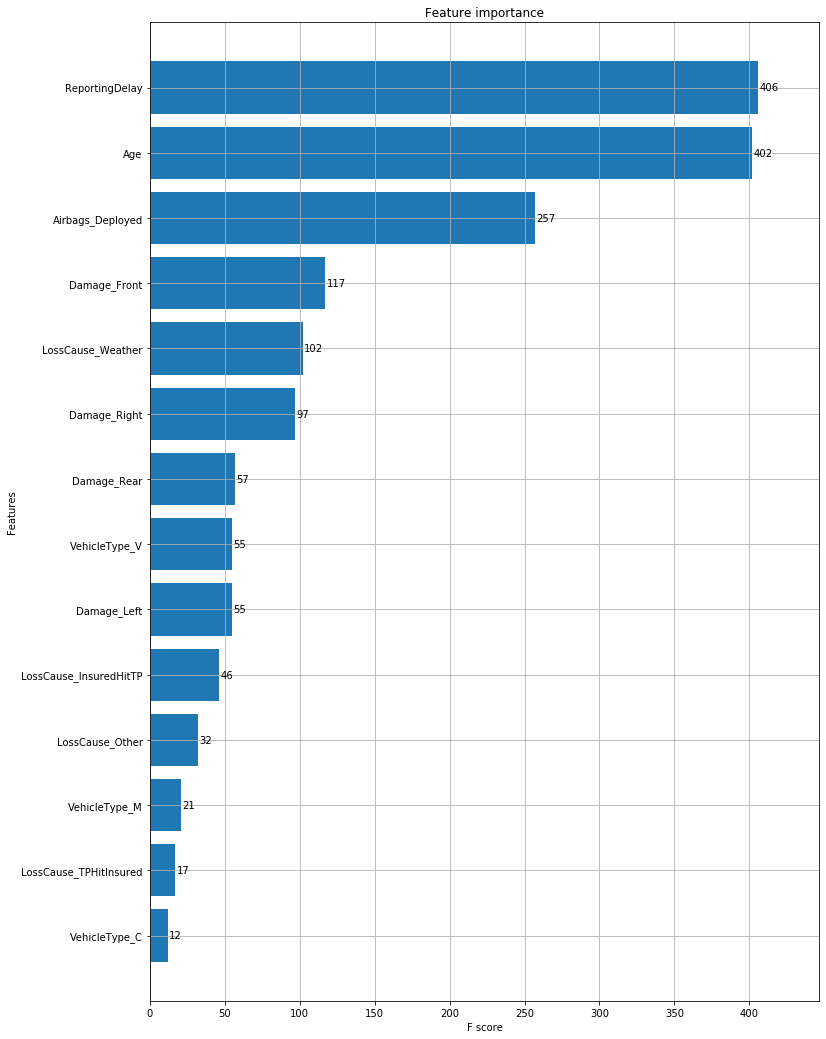

In [23]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()
fig.savefig('features.png')

In [16]:
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

from sklearn.metrics import average_precision_score

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()


def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

def get_features(train, test):
    trainval = list(train.columns.values)
    output = trainval
    return sorted(output)

print("Validating...")
check = model.predict(X_test, ntree_limit=model.best_iteration+1)

#area under the precision-recall curve
score = average_precision_score(y_test.values, check)
print('area under the precision-recall curve: {:.6f}'.format(score))


check2=check.round()
score = precision_score(y_test.values, check2)
print('precision score: {:.6f}'.format(score))

score = recall_score(y_test.values, check2)
print('recall score: {:.6f}'.format(score))

imp = model.feature_importances_
print('Importance array: ', imp)


print("Predict test set... ")
test_prediction = model.predict((y_test), ntree_limit=model.best_iteration+1)
score = average_precision_score(y_test.values, test_prediction)

print('area under the precision-recall curve test set: {:.6f}'.format(score))

Validating...
area under the precision-recall curve: 0.539683
precision score: 1.000000
recall score: 0.333333
Importance array:  [1.6531177e-01 0.0000000e+00 1.0839781e-01 0.0000000e+00 9.9606756e-03
 2.7569593e-03 0.0000000e+00 1.1178915e-01 6.0310063e-05 2.0893390e-04
 4.3501039e-03 4.1339055e-02 1.1763819e-02 5.2977279e-02 3.1074869e-02
 4.5112807e-01 8.8811629e-03]
Predict test set... 


ValueError: feature_names mismatch: ['Airbags_Deployed', 'LossCause_Fire', 'LossCause_InsuredHitTP', 'LossCause_MechanicalFailure', 'LossCause_Other', 'LossCause_TPHitInsured', 'LossCause_Theft', 'LossCause_Weather', 'VehicleType_C', 'VehicleType_M', 'VehicleType_V', 'ReportingDelay', 'Age', 'Damage_Front', 'Damage_Rear', 'Damage_Left', 'Damage_Right'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19']
expected Airbags_Deployed, LossCause_Fire, VehicleType_C, ReportingDelay, Damage_Front, LossCause_MechanicalFailure, LossCause_Weather, VehicleType_V, Damage_Left, Age, Damage_Rear, LossCause_Other, Damage_Right, LossCause_Theft, VehicleType_M, LossCause_InsuredHitTP, LossCause_TPHitInsured in input data
training data did not have the following fields: f17, f11, f8, f9, f3, f0, f6, f2, f5, f19, f15, f7, f1, f4, f10, f13, f16, f14, f18, f12

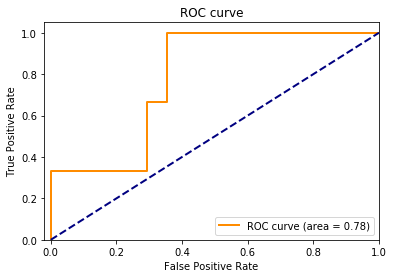

In [17]:
# Compute micro-average ROC curve and ROC area
check = model.predict(X_test, ntree_limit=model.best_iteration+1)

fpr, tpr, _ = roc_curve(y_test.values, check)
roc_auc = auc(fpr, tpr)
#xgb.plot_importance(gbm)
#plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

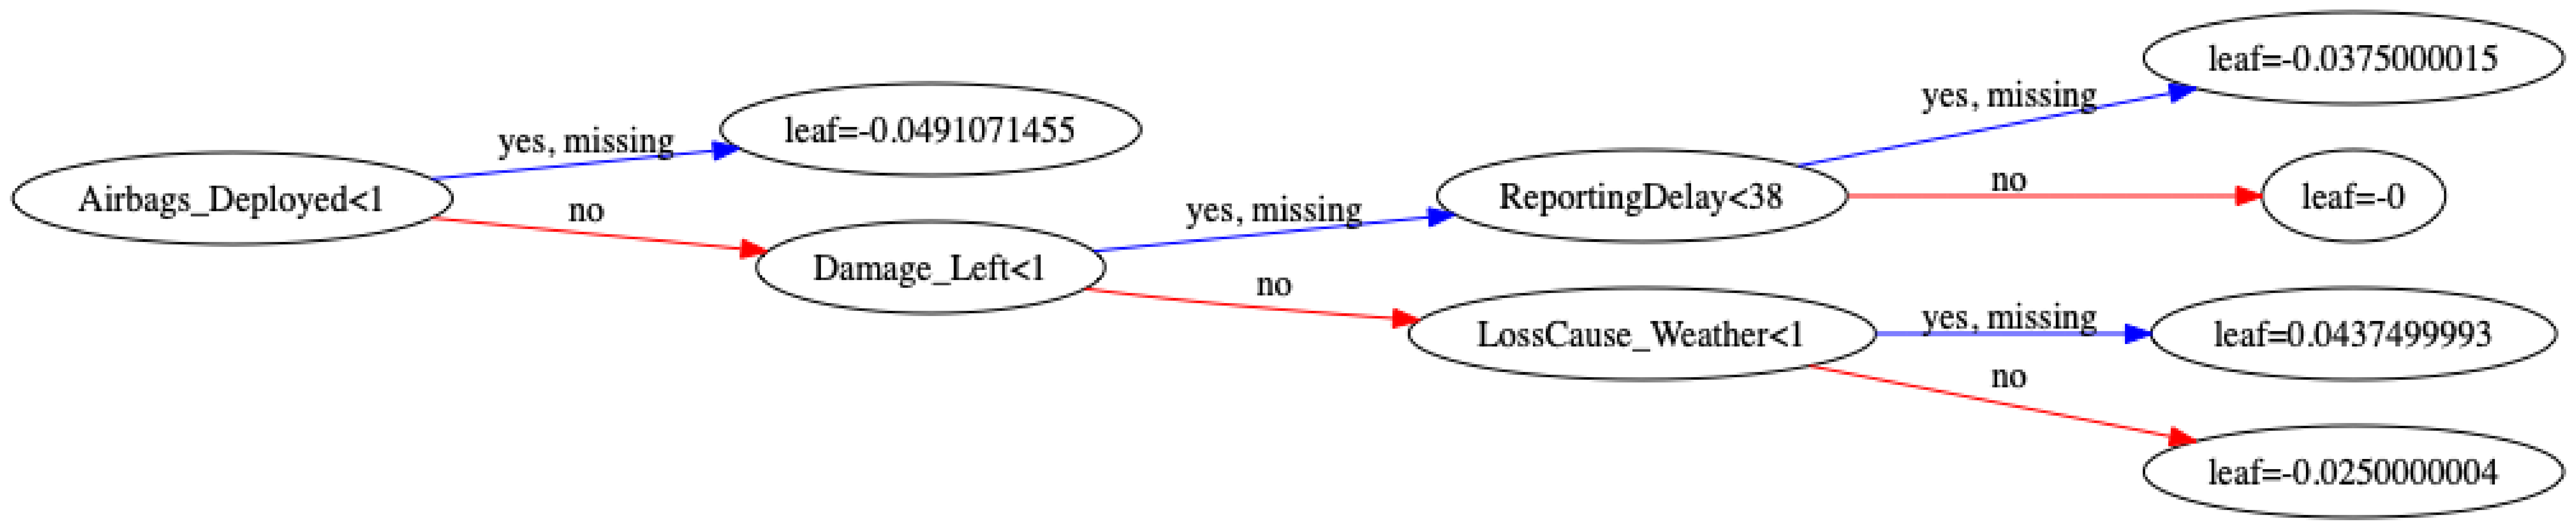

In [21]:
from xgboost import plot_tree

plot_tree(model, num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [19]:
from sklearn.metrics import confusion_matrix
from termcolor import colored
cm = confusion_matrix(y_test,(check>0.5))
print(colored('The confusion matrix is: ', 'red'),'\n',cm)

acc = (cm[0,0] + cm[1,1])/(cm[0,0]+cm[1,1]+cm[1,0]+cm[0,1])
print(colored("The accuracy on test set is: ", "blue"), colored(acc,"blue"))

The confusion matrix is:  
 [[17  0]
 [ 2  1]]
The accuracy on test set is:  0.9
